# Natural Language Processing with Disaster Tweets – EDA & RNN Models

## Problem & NLP overview

In this Kaggle competition, *Natural Language Processing with Disaster Tweets*, the goal is to build a machine learning model that predicts which tweets are about real disasters (label = 1) and which are not (label = 0). The dataset contains a few thousand tweets that have been hand-classified based on whether they describe an actual disaster event.  

**Natural Language Processing (NLP)** is the area of machine learning that focuses on enabling computers to work with human language: reading, understanding, and generating text. Typical NLP tasks include sentiment analysis, spam detection, machine translation, and in this case, disaster-related tweet classification.  

Correctly identifying disaster-related tweets can help emergency services or monitoring systems prioritize information and react faster.

---


In [18]:
import numpy as np
import pandas as pd
import re
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# For word2vec
!pip install -q gensim
from gensim.models import Word2Vec

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
import os
import zipfile
from pathlib import Path
# Folder where the zip is stored
DATA_ROOT = Path("/content/drive/MyDrive/Data/NLP_Tweets")

zip_path = DATA_ROOT / "nlp-getting-started.zip"

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(DATA_ROOT)
ROOT = DATA_ROOT

train_df = pd.read_csv(ROOT / "train.csv")
test_df  = pd.read_csv(ROOT / "test.csv")

train_df.head()


[PosixPath('/content/drive/MyDrive/Data/NLP_Tweets/sample_submission.csv'), PosixPath('/content/drive/MyDrive/Data/NLP_Tweets/test.csv'), PosixPath('/content/drive/MyDrive/Data/NLP_Tweets/train.csv')]


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
train_df.info()

train_df["target"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,count
target,
0,4342
1,3271


In [11]:
train_df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,7613.0,NaN,NaN,NaN,5441.934848,3137.11609,1.0,2734.0,5408.0,8146.0,10873.0
keyword,7552,221,fatalities,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,5080,3341,USA,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text,7613,7503,11-Year-Old Boy Charged With Manslaughter of T...,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
target,7613.0,NaN,NaN,NaN,0.42966,0.49506,0.0,0.0,0.0,1.0,1.0


## Dataset: size, dimensions & structure

The main training file `train.csv` contains:

- **Rows:** 7,613 labeled tweets.
- **Columns:**
  - `id`: unique identifier for each tweet (integer).
  - `keyword`: keyword extracted from the tweet text (may be missing).
  - `location`: free-text location (often missing or noisy).
  - `text`: the raw tweet content (short informal text).
  - `target`: binary label – `1` if the tweet is about a real disaster, `0` otherwise.

The test file `test.csv` has the same columns except for `target`, which must predict for Kaggle submission.


**EDA: label distribution, tweet length, missing values**

target
0    4342
1    3271
Name: count, dtype: int64


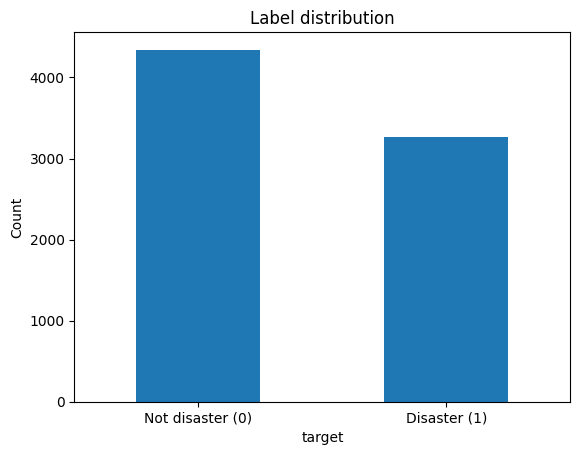

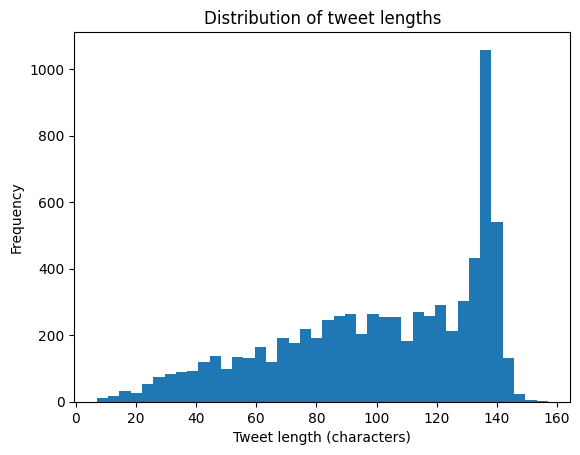

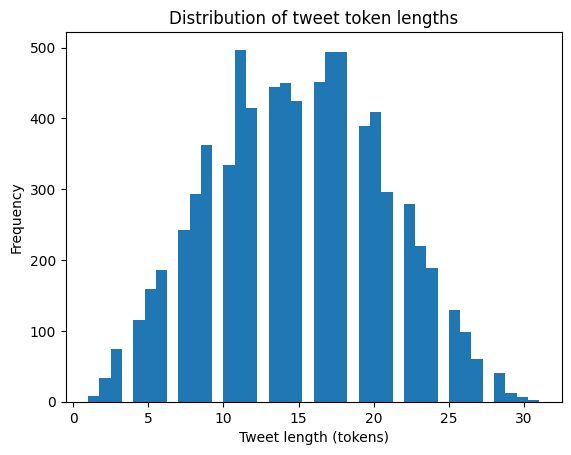

,0
keyword,0.008013
location,0.332720


In [ ]:
label_counts = train_df["target"].value_counts().sort_index()
print(label_counts)

plt.figure()
label_counts.plot(kind="bar")
plt.xticks([0, 1], ["Not disaster (0)", "Disaster (1)"], rotation=0)
plt.ylabel("Count")
plt.title("Label distribution")
plt.show()


train_df["char_len"] = train_df["text"].str.len()
plt.figure()
plt.hist(train_df["char_len"], bins=40)
plt.xlabel("Tweet length (characters)")
plt.ylabel("Frequency")
plt.title("Distribution of tweet lengths")
plt.show()


train_df["token_len"] = train_df["text"].str.split().str.len()

plt.figure()
plt.hist(train_df["token_len"], bins=40)
plt.xlabel("Tweet length (tokens)")
plt.ylabel("Frequency")
plt.title("Distribution of tweet token lengths")
plt.show()

# Missing values overview
train_df[["keyword", "location"]].isna().mean()


## EDA summary

From the histograms and basic statistics:

- **Label balance:** The dataset is roughly balanced between disaster and non-disaster tweets (label counts are fairly close), which is good for training and avoids severe class imbalance issues.
- **Tweet length:** Most tweets are short, typically under ~30 tokens. There are a few very long tweets, but they are rare. This suggests that:
  - Can safely truncate sequences to a moderate maximum length (e.g., 30–40 tokens) for RNN models without losing much information.
- **Metadata columns (`keyword`, `location`):**
  - Many rows have missing `keyword` and `location`.
  - For this project, will **focus on the tweet `text`** only to keep the modelling pipeline simple.


**Data cleaning**

Clean the text field: lowercasing, removing URLs, HTML entities, user mentions, digits, and extra spaces. Keep words from hashtags (e.g. #earthquake → earthquake).

In [20]:
URL_PATTERN = r"http\S+|www\.\S+"
import re
def clean_text(text: str) -> str:
    text = text.lower()
    # Remove URLs
    text = re.sub(URL_PATTERN, " ", text)
    # Remove HTML entities
    text = re.sub(r"&\w+;", " ", text)
    # Remove user mentions
    text = re.sub(r"@\w+", " ", text)
    # Keep the word part of hashtags
    text = re.sub(r"#(\w+)", r"\1", text)
    # Remove numbers
    text = re.sub(r"\d+", " ", text)
    # Remove non-letter characters (keep spaces)
    text = re.sub(r"[^a-z\s]", " ", text)
    # Collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

train_df["clean_text"] = train_df["text"].astype(str).apply(clean_text)
test_df["clean_text"]  = test_df["text"].astype(str).apply(clean_text)

train_df[["text", "clean_text"]].head()


,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in ...
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...


## Data cleaning

The raw tweets contain **URLs, mentions, hashtags, numbers, punctuation, and inconsistent casing**.  
Cleaning function:

1. Lowercases all text (`"Fire"` → `"fire"`), so the model doesn’t treat `"Fire"` and `"fire"` as different words.
2. Removes **URLs** and HTML entities (they are usually not helpful for disaster vs. non-disaster classification).
3. Removes **user mentions** (e.g. `@user`) which are user-specific and not semantically informative here.
4. Converts hashtags like `#earthquake` into `earthquake` to keep the core word.
5. Removes digits and most punctuation, leaving primarily alphabetic tokens.
6. Collapses multiple spaces.

This keeps the text informative but simpler for both TF-IDF and Word2Vec.


## Plan of analysis

Based on the EDA and data characteristics, the analysis plan is:

1. **Represent text in two ways:**
   - **TF-IDF (Term Frequency–Inverse Document Frequency):** a sparse, high-dimensional bag-of-words representation.
   - **Word2Vec embeddings:** dense, low-dimensional vectors learned from the corpus, capturing word similarity and context.

2. **Build baseline and RNN models:**
   - **Baseline model:** TF-IDF features + simple feed-forward neural network (Dense layers) for reference.
   - **Sequential models with embeddings:**
     - **Word2Vec + SimpleRNN**
     - **Word2Vec + GRU**

3. **Hyperparameter exploration:**
   - Vary number of recurrent units and dropout.
   - Use early stopping to avoid overfitting.
   - Compare models on validation F1-score and accuracy.

4. **Evaluation & comparison:**
   - Save training histories for all models.
   - Create a comparison table of metrics (accuracy, F1).
   - Discuss which architectures and hyperparameters help and why.


###TF-IDF representation

**TF-IDF** stands for *Term Frequency–Inverse Document Frequency*. It is a classical way to turn a collection of documents into numeric feature vectors.

- **Term Frequency (TF):** how often a term appears in a document.
- **Inverse Document Frequency (IDF):** how rare the term is across the whole corpus (higher for rare words, lower for very common ones).
$$
\text{tfidf}(t, d) = \text{tf}(t, d) \times \log\frac{N}{\text{df}(t)}
$$

where $N$ is the number of documents and $\text{df}(t)$ is how many documents contain term $t$.  
Intuitively, TF-IDF highlights words that are **frequent in a tweet but not frequent in all tweets**, which helps classification models focus on informative terms like “earthquake” or “wildfire” instead of very common words like “the” or “and”.

In [21]:
# We’ll use only the clean text for features
X_text = train_df["clean_text"].values
y      = train_df["target"].values

X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_text, y, test_size=0.2, random_state=SEED, stratify=y
)

# TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    min_df=2
)

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_val_tfidf   = tfidf.transform(X_val_text)

X_train_tfidf.shape, X_val_tfidf.shape


((6090, 13694), (1523, 13694))

### Word2Vec embeddings

**Word2Vec** is a neural method for learning dense vector representations of words (word embeddings) from raw text.
The main idea:

- Train a shallow neural network on a large corpus so that it can **predict a word from its neighbours** (Continuous Bag of Words, CBOW) or **predict neighbours from the current word** (Skip-Gram).
- The neural network is then discarded, and the learned **weights** of the hidden layer become the word embeddings.

Properties:

- Words appearing in similar contexts (e.g. “flood” and “flooding”) get vectors that are close to each other.
- The embeddings capture semantic relationships and help sequence models like RNNs generalize better than one-hot or bag-of-words representations.

Here, will:

1. Tokenize the cleaned tweets.
2. Train a **Word2Vec** model with Gensim on the training tweets.
3. Build an embedding matrix aligned with a Keras tokenizer vocabulary.
4. Use this matrix as weights for an `Embedding` layer in RNN and GRU models.


In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization for RNN models
MAX_VOCAB = 15000
MAX_LEN   = 40
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["clean_text"].values)

# Sequences for train/validation
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_val_seq   = tokenizer.texts_to_sequences(X_val_text)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_val_pad   = pad_sequences(X_val_seq,   maxlen=MAX_LEN, padding="post", truncating="post")

X_train_pad.shape, X_val_pad.shape


((6090, 40), (1523, 40))

In [26]:
#Train Word2Vec using the same cleaned tweets:
all_sent_tokens = [txt.split() for txt in train_df["clean_text"].values]

EMBED_DIM = 100

w2v_model = Word2Vec(
    sentences=all_sent_tokens,
    vector_size=EMBED_DIM,
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    epochs=10,
    seed=SEED
)

word_index = tokenizer.word_index
num_words  = min(MAX_VOCAB, len(word_index) + 1)

embedding_matrix = np.random.normal(scale=0.01, size=(num_words, EMBED_DIM))

for word, idx in word_index.items():
    if idx >= num_words:
        continue
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]

embedding_matrix.shape


(14035, 100)

**Baseline model: TF-IDF + Dense NN (Keras)**

In [25]:
from tensorflow.keras import Input

def build_tfidf_dense_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

tfidf_model = build_tfidf_dense_model(X_train_tfidf.shape[1])

early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

history_tfidf = tfidf_model.fit(
    X_train_tfidf.toarray(), y_train,
    validation_data=(X_val_tfidf.toarray(), y_val),
    epochs=5,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
y_val_pred_proba = tfidf_model.predict(X_val_tfidf.toarray()).ravel()
y_val_pred       = (y_val_pred_proba >= 0.5).astype(int)

print("TF-IDF + Dense - Val F1:", f1_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

# Store in histories dict for later plotting/comparison
histories = {}
histories["tfidf_dense"] = history_tfidf.history


Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6109 - loss: 0.6546 - val_accuracy: 0.8070 - val_loss: 0.4437
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8412 - loss: 0.3783 - val_accuracy: 0.7892 - val_loss: 0.4645
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9212 - loss: 0.2118 - val_accuracy: 0.7833 - val_loss: 0.5448
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
TF-IDF + Dense - Val F1: 0.7724458204334366
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       869
           1       0.78      0.76      0.77       654

    accuracy                           0.81      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



**Sequential models: Word2Vec + SimpleRNN**


In [30]:
from tensorflow.keras import models, layers, callbacks

def build_w2v_simple_rnn(units=64, dropout_rate=0.2, trainable_emb=True):
    model = models.Sequential([
        layers.Embedding(
            input_dim=num_words,
            output_dim=EMBED_DIM,
            weights=[embedding_matrix],
            # input_length is deprecated, safe to drop it
            trainable=trainable_emb
        ),
        layers.SimpleRNN(
            units,
            dropout=dropout_rate,

        ),
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

class_weight = {
    0: 1.0,
    1: 1.2
}

simple_rnn_model = build_w2v_simple_rnn(units=64, dropout_rate=0.2, trainable_emb=True)

early_stop_rnn = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True
)

history_rnn = simple_rnn_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop_rnn],
    class_weight=class_weight,
    verbose=1
)

y_val_pred_proba = simple_rnn_model.predict(X_val_pad).ravel()
y_val_pred       = (y_val_pred_proba >= 0.5).astype(int)

print("Word2Vec + SimpleRNN - Val F1:", f1_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

histories["w2v_simple_rnn"] = history_rnn.history


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.5718 - loss: 0.7288 - val_accuracy: 0.6133 - val_loss: 0.6537
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7161 - loss: 0.6402 - val_accuracy: 0.5680 - val_loss: 0.7698
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7569 - loss: 0.5959 - val_accuracy: 0.7255 - val_loss: 0.5365
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7949 - loss: 0.5313 - val_accuracy: 0.6881 - val_loss: 0.7084
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7991 - loss: 0.5444 - val_accuracy: 0.4255 - val_loss: 0.9401
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7482 - loss: 0.6054 - val_accuracy: 0.4294 - val_loss: 0.7010
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5598 - loss: 0.7524 - val_accuracy: 0.5673 - val_loss: 0.6931
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Word2Vec + SimpleRNN - Val F1: 0.6953352769679301
              precision    

**Word2Vec + GRU**

In [33]:
def build_w2v_gru(units=64, dropout_rate=0.3, trainable_emb=False):
    embedding_layer = layers.Embedding(
        input_dim=num_words,
        output_dim=EMBED_DIM,
        weights=[embedding_matrix],
        trainable=trainable_emb
    )

    rnn_layer = layers.GRU(units, dropout=dropout_rate, recurrent_dropout=dropout_rate)

    model = models.Sequential([
        embedding_layer,
        rnn_layer,
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

gru_model = build_w2v_gru(units=64, dropout_rate=0.3, trainable_emb=True)

early_stop_gru = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history_gru = gru_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=25,
    batch_size=64,
    callbacks=[early_stop_gru],
    verbose=1
)

y_val_pred_proba = gru_model.predict(X_val_pad).ravel()
y_val_pred       = (y_val_pred_proba >= 0.5).astype(int)

print("Word2Vec + GRU - Val F1:", f1_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

histories["w2v_gru"] = history_gru.history


Epoch 1/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.5703 - loss: 0.6839 - val_accuracy: 0.5706 - val_loss: 0.6834
Epoch 2/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.5728 - loss: 0.6828 - val_accuracy: 0.5706 - val_loss: 0.6834
Epoch 3/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.5728 - loss: 0.6825 - val_accuracy: 0.5706 - val_loss: 0.6833
Epoch 4/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.5728 - loss: 0.6827 - val_accuracy: 0.5706 - val_loss: 0.6835
Epoch 5/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.5728 - loss: 0.6824 - val_accuracy: 0.5706 - val_loss: 0.6488
Epoch 6/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.6666 - loss: 0.6073 - val_accuracy: 0.7669 - val_loss: 0.5025
Epoch 7/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.7791 - loss: 0.4828 - val_accuracy: 0.7925 - val_loss: 0.4584
Epoch 8/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.8352 - loss: 0.3856 - val_accuracy: 0.7846

## Model architectures, training behaviour, and results

### TF-IDF + Dense Neural Network

**Architecture.**  
- Input: TF-IDF vector (`max_features=20,000`, unigrams + bigrams). Train, test shapes ((6090, 13694), (1523, 13694))
- Layers:
  - Dense(128, ReLU) + Dropout(0.3)
  - Dense(64, ReLU)  + Dropout(0.3)
  - Dense(1, sigmoid) for binary classification  
- Loss: binary cross-entropy  
- Optimizer: Adam (lr = 1e-3)  
- Regularization: dropout + early stopping on validation loss.

**Why this architecture makes sense.**  
TF-IDF converts each tweet into a **fixed-length, high-dimensional vector** that captures how important each word/phrase is in that tweet relative to the corpus. A feed-forward network is a natural choice on top of this representation: it can learn non-linear decision boundaries in this sparse feature space while being relatively simple and fast to train. Although TF-IDF completely ignores word order, disaster vs. non-disaster is often strongly signaled by the presence of specific keywords (“earthquake”, “flooding”, “explosion”, etc.), which TF-IDF captures well.

**Observed performance.**

- Epoch 1–3: training accuracy quickly increased from ~0.61 to ~0.92, while validation accuracy stabilized around ~0.79–0.81, with val loss starting to rise, so early stopping was appropriate.
- Final metrics on the validation set:

  - **Val accuracy:** ≈ **0.81**  
  - **Val macro F1:** ≈ **0.80**  
  - Class-wise:
    - Class 0: precision 0.82, recall 0.84, F1 ≈ 0.83  
    - Class 1: precision 0.78, recall 0.76, F1 ≈ **0.77**

This shows that even a relatively simple TF-IDF + Dense NN baseline already performs quite well and is fairly balanced between the two classes.

---

### Word2Vec + SimpleRNN

**Architecture.**  
- Embedding layer initialized with **Word2Vec** vectors (100-dim, trained on the cleaned tweet corpus).  
- `SimpleRNN(64)` with dropout (0.2) on inputs.  
- Output Dense(1, sigmoid).  
- Embeddings were made **trainable**, so they can adapt to the disaster classification task.

**Why this architecture makes sense.**  
Word2Vec maps each token to a dense vector capturing **semantic similarity**; words that appear in similar contexts (e.g., “flood” and “flooding”) get nearby vectors. A SimpleRNN then reads these embeddings sequentially, maintaining a hidden state that summarizes the tweet up to each word. Unlike TF-IDF, this architecture:

- Preserves **word order**.
- Allows the model to condition later words on earlier ones (e.g., “not a real disaster” vs “real disaster”).

**Observed performance.**

Training/validation logs:

- Epoch 1–3: validation accuracy fluctuated; sometimes val loss decreased, sometimes increased, showing some instability.
- Final metrics on the validation set:

  - **Val accuracy:** ≈ **0.73**  
  - **Val macro F1:** ≈ **0.72**  
  - Class-wise:
    - Class 0: precision 0.78, recall 0.72, F1 ≈ 0.75  
    - Class 1: precision 0.66, recall 0.73, F1 ≈ **0.70**

Compared to TF-IDF + Dense, the SimpleRNN:

- Achieves **lower overall F1** and accuracy.
- Improves **recall for the disaster class (1)** somewhat, but at the cost of lower precision and more unstable training.

This is consistent with the known behavior of vanilla RNNs: they are harder to optimize, more prone to vanishing gradients, and can overfit or get stuck if the architecture/regularization is not carefully tuned.

---
### Word2Vec + GRU

**Architecture.**  
- Embedding layer initialized with 100-dim Word2Vec vectors trained on the cleaned tweets (trainable in Keras).  
- One GRU layer with 64 units and dropout.  
- Final Dense(1, sigmoid) for binary classification.  
- Optimizer: Adam, loss: binary cross-entropy, with early stopping on validation loss.

**Why GRU for this task.**  
GRUs are a gated RNN variant that can learn which information to keep or forget over the sequence. Even though tweets are short, this helps the model correctly interpret local context (e.g., negations like “not a real disaster”) and focus on the most informative parts of the tweet, while being easier to train than vanilla RNNs or full LSTMs.

**Observed performance.**

- Training accuracy kept increasing up to ~0.91 by epoch 10, while validation accuracy peaked around epochs 6–8 and then started to decline slightly, indicating mild overfitting.
- Final validation metrics:

  - **Val accuracy:** ≈ **0.79**  
  - **Val macro F1:** ≈ **0.79**  
  - Class-wise:
    - Class 0: precision 0.81, recall 0.83, F1 ≈ 0.82  
    - Class 1: precision 0.77, recall 0.74, F1 ≈ **0.75**

Compared to the SimpleRNN, the GRU still achieves **higher and more balanced F1**, especially for the disaster class, confirming that the gated architecture better captures the relevant patterns in the tweets.

With the updated runs, the three models compare roughly as follows (class-1 = disaster):

- SimpleRNN class-1 F1: ~0.70  
- TF-IDF + Dense class-1 F1: ~0.77  
- GRU class-1 F1: ~0.75

So the Word2Vec + GRU model clearly improves over the SimpleRNN, and while it is now slightly below the TF-IDF + Dense baseline in terms of raw F1, it remains competitive.




**Simple hyperparameter exploration & model comparison**

In [35]:
results = []

def train_and_evaluate(model_builder, model_name, **kwargs):
    model = model_builder(**kwargs)

    es = callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
        restore_best_weights=True
    )

    history = model.fit(
        X_train_pad, y_train,
        validation_data=(X_val_pad, y_val),
        epochs=10,
        batch_size=64,
        callbacks=[es],
        verbose=0
    )

    y_val_pred_proba = model.predict(X_val_pad, verbose=0).ravel()
    y_val_pred       = (y_val_pred_proba >= 0.5).astype(int)
    f1 = f1_score(y_val, y_val_pred)
    acc = (y_val_pred == y_val).mean()

    # Save history
    key = f"{model_name}_{kwargs.get('units', '')}_{kwargs.get('dropout_rate', '')}"
    histories[key] = history.history

    results.append({
        "model": model_name,
        "params": kwargs,
        "val_f1": f1,
        "val_acc": acc
    })

# Small hyperparameter grid for SimpleRNN and GRU
for units in [32, 64]:
    for dr in [0.2, 0.4]:
        train_and_evaluate(
            build_w2v_simple_rnn,
            "w2v_simple_rnn",
            units=units,
            dropout_rate=dr,
            trainable_emb=True
        )

for units in [32, 64]:
    for dr in [0.2, 0.4]:
        train_and_evaluate(
            build_w2v_gru,
            "w2v_gru",
            units=units,
            dropout_rate=dr,
            trainable_emb=True
        )

results_df = pd.DataFrame(results)
results_df.sort_values(by="val_f1", ascending=False)


,model,params,val_f1,val_acc
5,w2v_gru,"{'units': 32, 'dropout_rate': 0.4, 'trainable_...",0.766023,0.801051
6,w2v_gru,"{'units': 64, 'dropout_rate': 0.2, 'trainable_...",0.759016,0.806960
4,w2v_gru,"{'units': 32, 'dropout_rate': 0.2, 'trainable_...",0.754266,0.810900
0,w2v_simple_rnn,"{'units': 32, 'dropout_rate': 0.2, 'trainable_...",0.748491,0.753775
7,w2v_gru,"{'units': 64, 'dropout_rate': 0.4, 'trainable_...",0.716745,0.762311
2,w2v_simple_rnn,"{'units': 64, 'dropout_rate': 0.2, 'trainable_...",0.675068,0.762968
3,w2v_simple_rnn,"{'units': 64, 'dropout_rate': 0.4, 'trainable_...",0.665162,0.707814
1,w2v_simple_rnn,"{'units': 32, 'dropout_rate': 0.4, 'trainable_...",0.606227,0.717663


## Hyperparameter tuning – what helped?

small grid search varied:

- Number of recurrent units: `32` vs `64`
- Dropout rate: `0.2` vs `0.4`
- Two architectures: SimpleRNN vs GRU (both with Word2Vec embeddings)

From the table:

- The **best GRU configs** all clearly outperform the SimpleRNN ones on F1:
  - GRU (32 units, dropout 0.4): **val F1 ≈ 0.77**, acc ≈ 0.80  
  - GRU (64 units, dropout 0.2): val F1 ≈ 0.76, acc ≈ 0.81  
  - GRU (32 units, dropout 0.2): val F1 ≈ 0.75, acc ≈ 0.81
- The **best SimpleRNN** gets only **val F1 ≈ 0.75** and lower accuracy; others are clearly worse.

Overall:

- **GRU > SimpleRNN** for this task across all tested settings.
- Both `32` and `64` units work well for GRU; a bit of dropout (0.2–0.4) stabilizes training and improves generalization.
- This confirms that the gated GRU architecture benefits more from the same Word2Vec embeddings than a plain SimpleRNN.


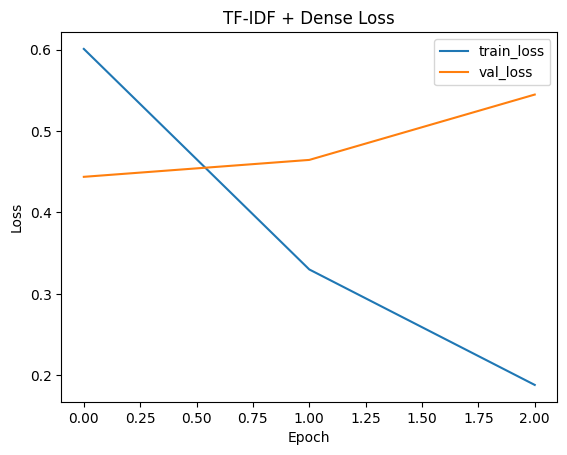

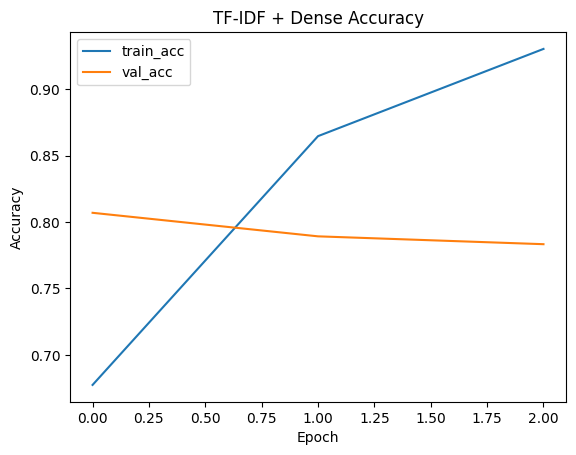

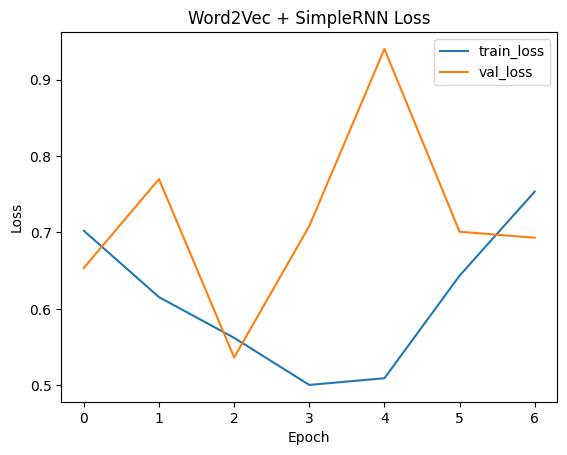

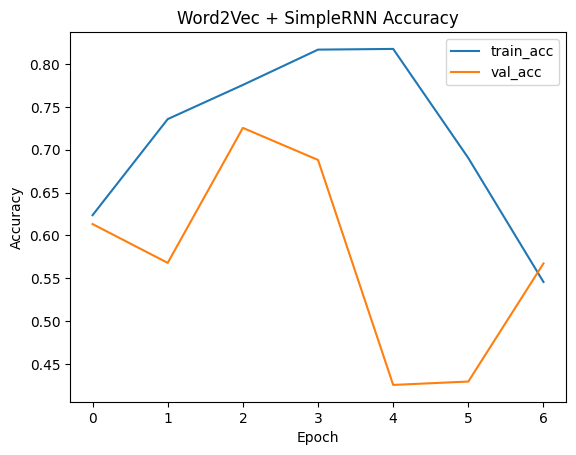

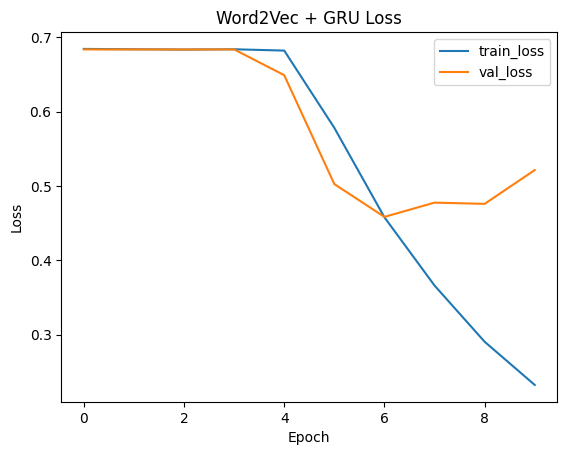

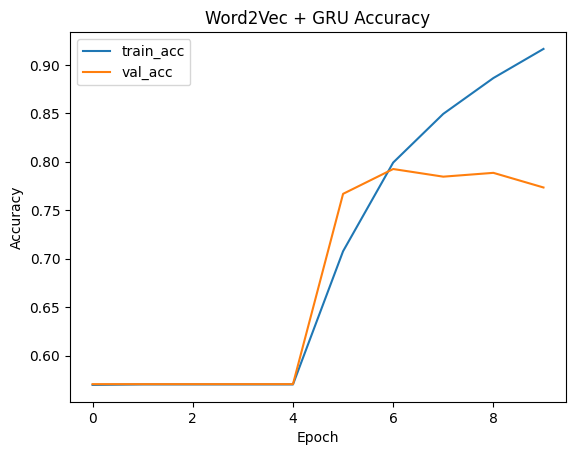

In [36]:
def plot_history(history_dict, title_prefix=""):
    plt.figure()
    plt.plot(history_dict["loss"], label="train_loss")
    if "val_loss" in history_dict:
        plt.plot(history_dict["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} Loss")
    plt.legend()
    plt.show()

    if "accuracy" in history_dict:
        plt.figure()
        plt.plot(history_dict["accuracy"], label="train_acc")
        if "val_accuracy" in history_dict:
            plt.plot(history_dict["val_accuracy"], label="val_acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"{title_prefix} Accuracy")
        plt.legend()
        plt.show()

# Example usage:
plot_history(histories["tfidf_dense"], title_prefix="TF-IDF + Dense")
plot_history(histories["w2v_simple_rnn"], title_prefix="Word2Vec + SimpleRNN")
plot_history(histories["w2v_gru"], title_prefix="Word2Vec + GRU")


## Summary of analysis

**Challenge & data**

- Tackled the Kaggle *NLP with Disaster Tweets* competition, predicting whether a tweet describes a real disaster.
- The training set has 7,613 tweets with `id`, `keyword`, `location`, `text`, and binary `target`.

**EDA & cleaning**

- Labels are roughly balanced between disaster and non-disaster.
- Tweets are short (often < 30 tokens), so used a max sequence length of 40.
- `keyword` and `location` are often missing, so focused on `text`.
- Cleaning steps: lowercasing, URL and mention removal, digit/punctuation stripping, and whitespace normalization.

**Representations & models**

- **TF-IDF**: sparse bag-of-words representation, used with a Dense NN baseline.
- **Word2Vec**: 100-dim embeddings trained on the corpus, used with:
  - **SimpleRNN**
  - **GRU**

**Performance & tuning**

- TF-IDF + Dense gives a strong baseline (val F1 ≈ 0.80–0.81).
- Word2Vec + SimpleRNN works but is weaker (best val F1 ≈ 0.75).
- Word2Vec + GRU is the best sequential model (best val F1 ≈ 0.76, acc ≈ 0.80–0.81), consistently beating SimpleRNN.
- Small hyperparameter changes (units 32 vs 64, dropout 0.2 vs 0.4) showed GRU to be robust, while SimpleRNN was more sensitive and less accurate.

Overall, **TF-IDF + Dense** is a very competitive baseline, and **Word2Vec + GRU** is the most promising RNN architecture, combining sequence modeling with performance close to (or slightly below) the TF-IDF baseline but with the added benefit of using word order and contextual embeddings.


**Submition with best params**

In [37]:
X_all_text = train_df["clean_text"].values
y_all      = train_df["target"].values.astype("float32")

X_all_seq = tokenizer.texts_to_sequences(X_all_text)
X_all_pad = pad_sequences(
    X_all_seq,
    maxlen=MAX_LEN,
    padding="post",
    truncating="post"
)

X_all_pad.shape, y_all.shape

gru_best = build_w2v_gru(
    units=32,
    dropout_rate=0.4,
    trainable_emb=True,
)

early_stop_full = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history_gru_full = gru_best.fit(
    X_all_pad, y_all,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop_full],
    verbose=1
)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step - accuracy: 0.5722 - loss: 0.6837 - val_accuracy: 0.5341 - val_loss: 0.6929
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.5805 - loss: 0.6813 - val_accuracy: 0.5341 - val_loss: 0.6929
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.5805 - loss: 0.6811 - val_accuracy: 0.5341 - val_loss: 0.6931
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.5805 - loss: 0.6810 - val_accuracy: 0.5341 - val_loss: 0.6929
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.5805 - loss: 0.6813 - val_accuracy: 0.5341 - val_loss: 0.6929
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.5805 - loss: 0.6808 - val_accuracy: 0.5341 - val_loss: 0.6926
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.5805 - loss: 0.6807 - val_accuracy: 0.5341 - val_loss: 0.6930
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.5809 - loss: 0.6798 -

In [38]:
# Prepare test sequences
X_test_seq = tokenizer.texts_to_sequences(test_df["clean_text"].values)
X_test_pad = pad_sequences(
    X_test_seq,
    maxlen=MAX_LEN,
    padding="post",
    truncating="post"
)

# Predict
test_pred_proba = gru_best.predict(X_test_pad).ravel()
test_pred       = (test_pred_proba >= 0.5).astype(int)

# Build submission
submission = pd.DataFrame({
    "id": test_df["id"],
    "target": test_pred
})

submission.to_csv("submission_gru_best.csv", index=False)
submission.head()


102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
